In [16]:
import pandas as pd
import numpy as np
import matplotlib as pl
import csv
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Link for the data https://www.foreignlaborcert.doleta.gov/docs/py2015q4/H-1B_Disclosure_Data_FY15_Q4.xlsx
#### Please convert the excel file to csv before loading it on the notebook

In [18]:
clean_data = []

def streaming(reader):
    for row in reader:
        yield (row['CASE_STATUS'], row['SOC_CODE'], row['PW_WAGE_LEVEL'], row['TOTAL WORKERS'], \
           row['FULL_TIME_POSITION'], row['EMPLOYER_CITY'], row['H-1B_DEPENDENT'], row['WILLFUL VIOLATOR'])

with open('H-1B_Disclosure_Data_FY15_Q4.csv', 'r') as fi:
    reader = csv.DictReader(fi)
    for row in streaming(reader):
        clean_data.append(row)

In [19]:
columns = ['CASE_STATUS', 'SOC_CODE', 'PW_WAGE_LEVEL', 'TOTAL WORKERS', 'FULL_TIME_POSITION',\
           'EMPLOYER_CITY', 'H-1B_DEPENDENT', u'WILLFUL_VIOLATOR']
analysis_data = pd.DataFrame(clean_data, columns=columns)
analysis_data.drop('EMPLOYER_CITY', axis=1, inplace=True)
analysis_data.dropna(inplace=True)
analysis_data.head()

,CASE_STATUS,SOC_CODE,PW_WAGE_LEVEL,TOTAL WORKERS,FULL_TIME_POSITION,H-1B_DEPENDENT,WILLFUL_VIOLATOR
0,WITHDRAWN,17-2141.00,Level I,1,Y,N,N
1,CERTIFIED,25-1032,Level I,1,Y,N,N
2,WITHDRAWN,15-1799,Level II,1,Y,N,N
3,CERTIFIED,17-2072,Level I,2,Y,N,N
4,CERTIFIED,15-1131,Level IV,1,Y,N,N


In [ ]:
# pd.get_dummies(analysis_data, columns=[u'SOC_CODE', u'PW_WAGE_LEVEL', u'FULL_TIME_POSITION', u'H-1B_DEPENDENT',
#                                        u'WILLFUL_VIOLATOR'])

In [20]:
analysis_data['TOTAL WORKERS'] = pd.to_numeric(analysis_data['TOTAL WORKERS'], errors='coerce')

In [21]:
analysis_data.head(3)

,CASE_STATUS,SOC_CODE,PW_WAGE_LEVEL,TOTAL WORKERS,FULL_TIME_POSITION,H-1B_DEPENDENT,WILLFUL_VIOLATOR
0,WITHDRAWN,17-2141.00,Level I,1.0,Y,N,N
1,CERTIFIED,25-1032,Level I,1.0,Y,N,N
2,WITHDRAWN,15-1799,Level II,1.0,Y,N,N


In [43]:
print len(analysis_data)
analysis_data.dropna(inplace=True)
print len(analysis_data)
analysis_data.reset_index(inplace=True, drop=True)
# analysis_data['TOTAL WORKERS'] = analysis_data['TOTAL WORKERS'].apply(lambda x: int(x))

618789
618789


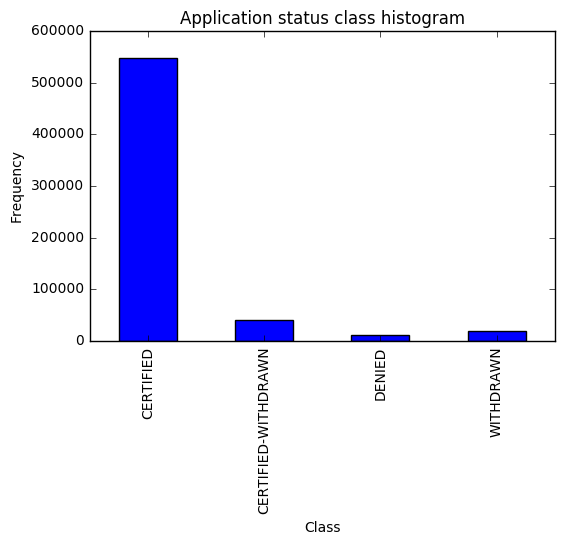

In [23]:
val_count = pd.value_counts(analysis_data['CASE_STATUS'], sort = True).sort_index()
val_count.plot(kind = 'bar')
plt.title("Application status class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [76]:
X = analysis_data.ix[:, analysis_data.columns != 'CASE_STATUS']
y = analysis_data.ix[:, analysis_data.columns == 'CASE_STATUS']

#### Analysing only Denied and Certified applications. We can later add Certified-Withdrawn as part of Certified

In [77]:
# Number of data points in the minority class
number_records_denied = len(analysis_data[analysis_data.CASE_STATUS == 'DENIED'])
denied_indices = np.array(analysis_data[analysis_data.CASE_STATUS == 'DENIED'].index)

# Picking the indices of the normal classes
normal_indices = analysis_data[analysis_data.CASE_STATUS == 'CERTIFIED'].index

# Out of the indices we picked, randomly select "x" number (number_records_denied)
random_normal_indices = np.random.choice(normal_indices, number_records_denied, replace = False)
# random_normal_indices = np.array(random_normal_indices)

In [78]:
# Appending the 2 indices
under_sample_indices = np.concatenate([denied_indices,random_normal_indices])

# Under sample dataset
under_sample_data = analysis_data.iloc[under_sample_indices,:]
under_sample_data.reset_index(inplace=True, drop=True)

# Showing ratio
print("Percentage of certified applications: ", float(len(under_sample_data[under_sample_data.CASE_STATUS == 'CERTIFIED']))/len(under_sample_data))
print("Percentage of denied applications: ", float(len(under_sample_data[under_sample_data.CASE_STATUS == 'DENIED']))/len(under_sample_data))
print("Total number of applications in resampled data: ", len(under_sample_data))

('Percentage of certified applications: ', 0.5)
('Percentage of denied applications: ', 0.5)
('Total number of applications in resampled data: ', 21964)


In [79]:
under_sample_data = pd.get_dummies(under_sample_data, columns=[u'SOC_CODE', u'PW_WAGE_LEVEL', u'FULL_TIME_POSITION', u'H-1B_DEPENDENT',
                                           u'WILLFUL_VIOLATOR'])

In [80]:
under_sample_data.CASE_STATUS = under_sample_data.CASE_STATUS.astype('category')

In [81]:
cat_columns = under_sample_data.select_dtypes(['category']).columns
under_sample_data[cat_columns] = under_sample_data[cat_columns].apply(lambda x: x.cat.codes)

In [86]:
# CERTIFIED = 0, DENIED = 1

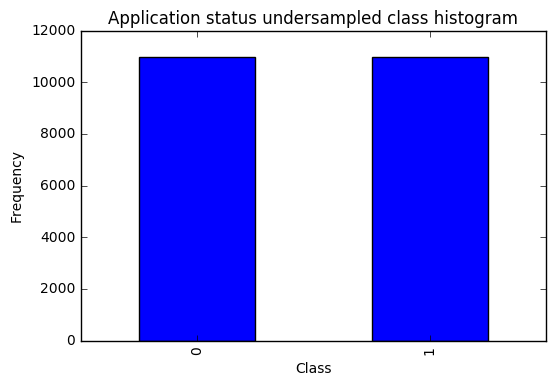

In [84]:
undersample_caseStatus = pd.value_counts(under_sample_data['CASE_STATUS'], sort = True).sort_index()
undersample_caseStatus.plot(kind = 'bar')
plt.title("Application status undersampled class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [88]:
X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'CASE_STATUS']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'CASE_STATUS']

In [91]:
# Splitting undersampled dataset
from sklearn.cross_validation import train_test_split
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("Number of applications train dataset: ", len(X_train_undersample))
print("Number of applications test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

('Number of applications train dataset: ', 15374)
('Number of applications test dataset: ', 6590)
('Total number of transactions: ', 21964)


In [93]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train_undersample, y_train_undersample)

In [94]:
clf.score(X_train_undersample,y_train_undersample)

0.72915311564979834

In [95]:
clf.score(X_test_undersample,y_test_undersample)

0.66737481031866464